# Example Visualization with SOMs

### Imports

In [1]:
import seaborn.objects as so
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dbgsom.dbgsom_ import DBGSOM
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib.gridspec import GridSpec


## load data

In [2]:
fashion_mnist = pd.read_csv(
    "fashion-mnist_train.csv"
)

fashion_mnist_target = fashion_mnist.label
fashion_mnist_train = fashion_mnist.drop("label", axis=1)


### Defining and fitting the som

In [10]:
som = DBGSOM(
    max_neurons=50,
    spreading_factor=0.1,
    max_epochs=500,
    random_state=42,
)

scaler = StandardScaler()

pipe = Pipeline(
    steps=[
        ("scaler", scaler),
        ("som", som),
    ]
)

data = fashion_mnist_train

pipe.fit(data)


 55%|█████▍    | 273/500 [03:50<03:11,  1.19 epochs/s]


Pipeline(steps=[('scaler', StandardScaler()),
                ('som',
                 DBGSOM(max_epochs=500, max_neurons=50, random_state=42,
                        spreading_factor=0.1))])

### Plotting results

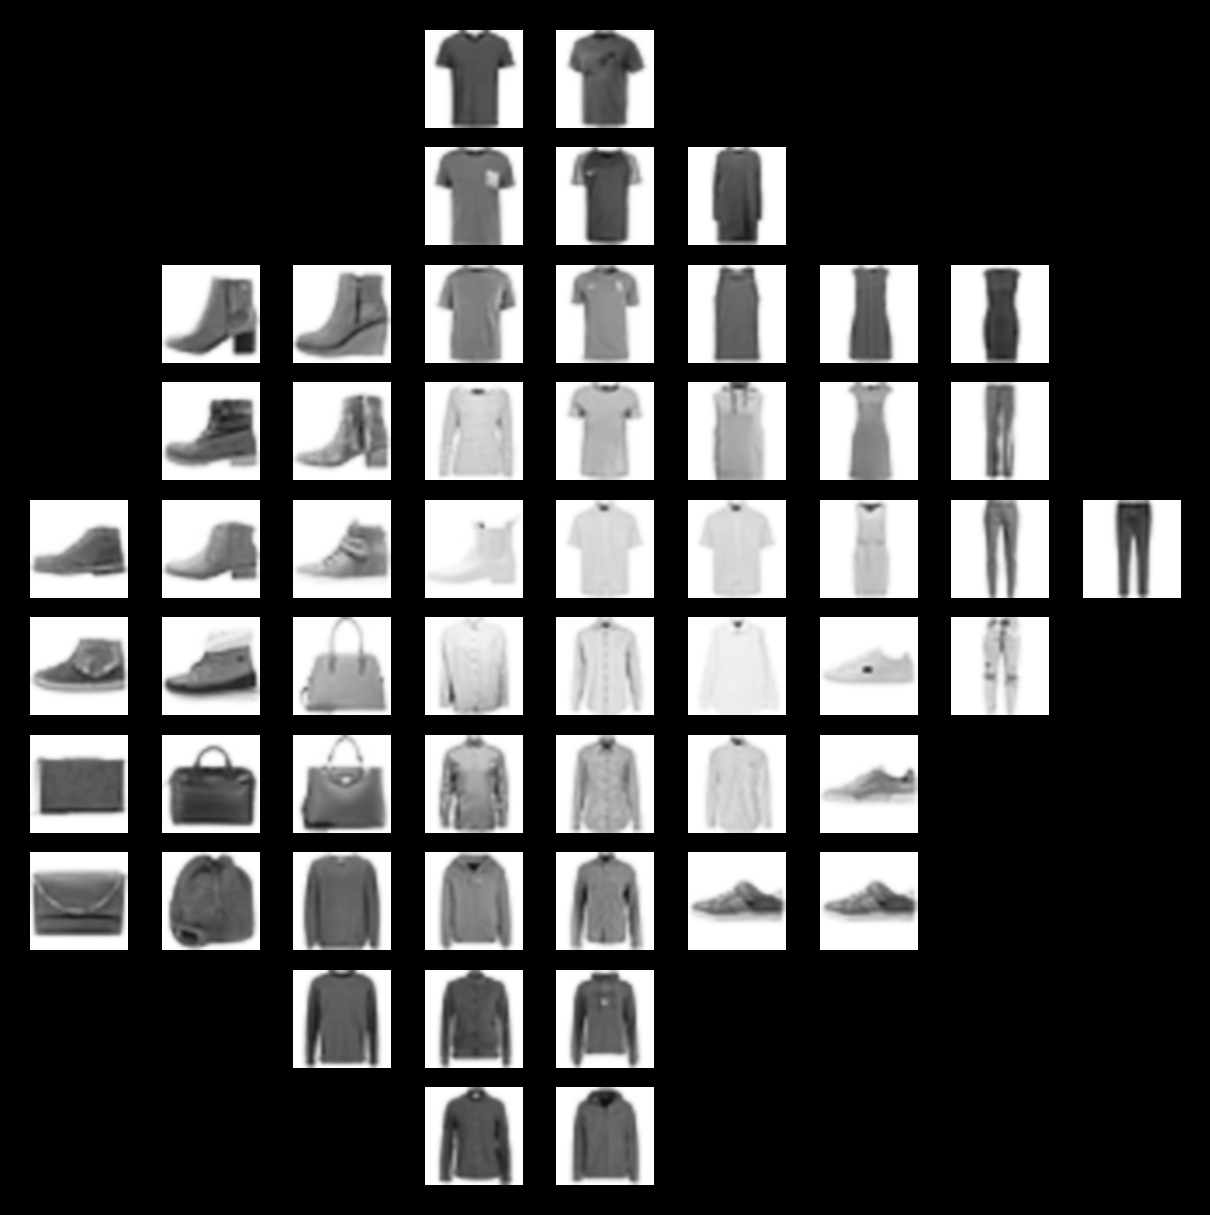

In [68]:
f = plt.figure(figsize=(5, 5), dpi=300)

som = pipe.named_steps["som"]

coordinates = np.array(som.neurons_)

min, max = (np.array(som.neurons_).min(), np.array(som.neurons_).max())
min_x = coordinates[:,0].min()
max_x = coordinates[:,0].max()
min_y = coordinates[:,1].min()
max_y = coordinates[:,1].max()

nearest_samples = pipe.transform(data).argmin(axis=0)

gs = GridSpec(nrows=max_x-min_x+1, ncols=max_y-min_y+1, figure=f)
for index, neuron in enumerate(coordinates):
    neuron -= [min_x, min_y]
    plt.subplot(gs[neuron[0], neuron[1]])
    # print(neuron>=9)
    plt.imshow(
        data.to_numpy()[nearest_samples[index]].reshape(28, 28), cmap="Greys", interpolation="bicubic"
    )
    plt.axis("off")

plt.savefig(fname="fashion_mnist.png")

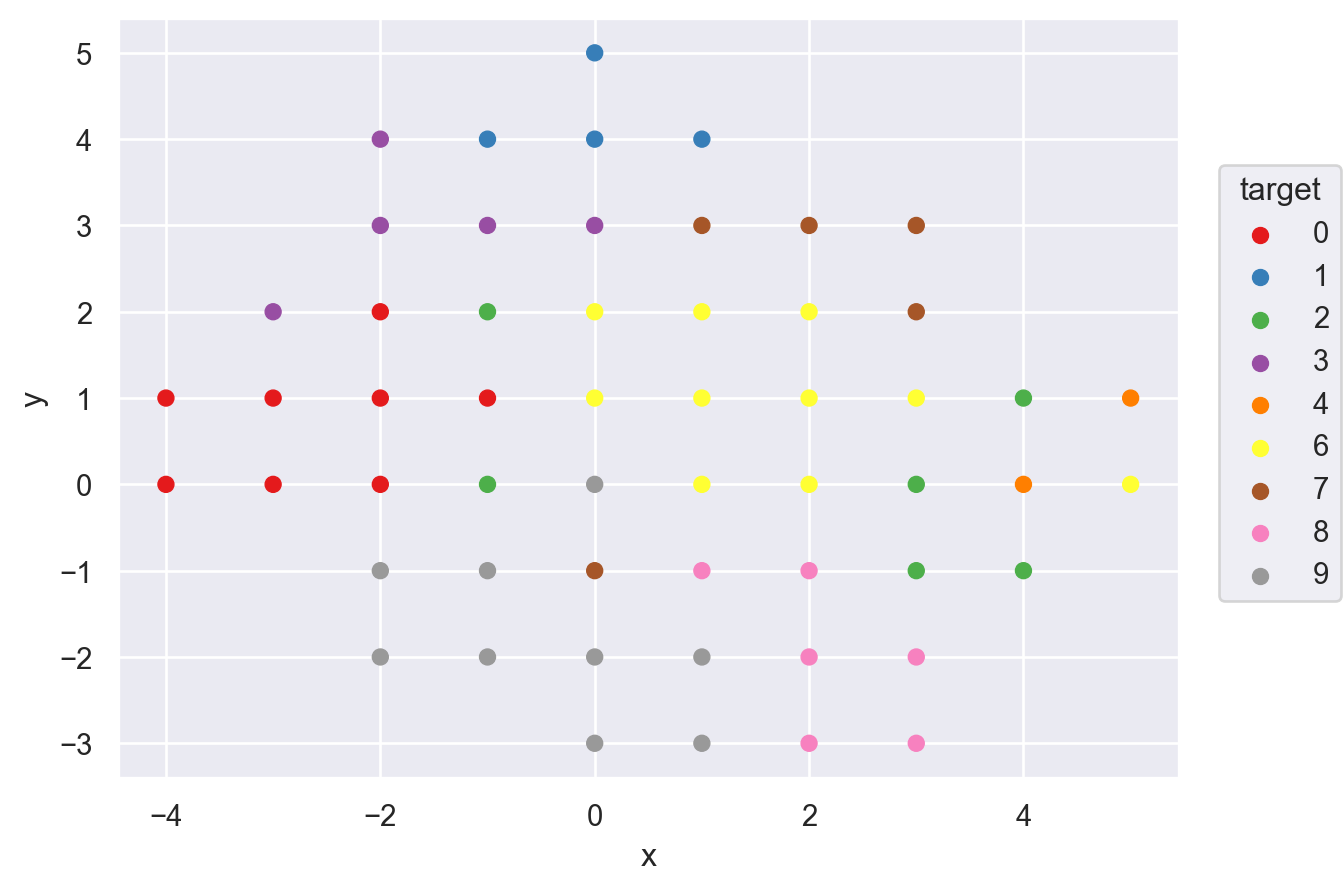

<Figure size 1500x1500 with 0 Axes>

In [ ]:
weights = pipe.named_steps["som"].weights_

f = plt.figure(figsize=(5, 5), dpi=300)

dots = pd.DataFrame(np.array(pipe.named_steps["som"].neurons_), columns=["x", "y"])
dots["epoch_created"] = list(
    dict(pipe.named_steps["som"].som_.nodes.data("epoch_created")).values()
)
dots["error"] = list(dict(pipe.named_steps["som"].som_.nodes.data("error")).values())
dots["target"] = fashion_mnist_target[nearest_samples].to_numpy()
p = so.Plot(dots, x="x", y="y", color="target").add(so.Dot()).scale(color="Set1").plot()
p
p.save(loc="fashion_mnist_map.png", bbox_inches="tight")


In [ ]:
som.growing_threshold_

9670.937761110274

In [ ]:
som.topographic_error_

0.11145